# Setup

In [1]:
%load_ext rpy2.ipython

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
paper_name = "risk_rayleigh"

import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")

# DO NOT RUN (for reading only) - Setup

In [ ]:
%%R
# DO NOT RUN THIS CELL, YOU NEED TO EXECUTE THIS MANUALLY IN THE TERMINAL
install.packages(c("expm","nloptr","PMA","ggplot2","ggthemes","foreach","data.table", "pracma","PMA","plyr","zoo","xts","shiny","lubridate","stringr","microbenchmark","esquisse","genlasso","elasticnet"), quiet=TRUE, verbose=FALSE)
install.packages(c("plyr","zoo","xts","lubridate","stringr","elasticnet","getnlasso"))




# algorithms.R

In [ ]:
%%R -i paper_name

#  algorithms.R


require(ggplot2)
require(ggthemes)
require(foreach)
require(data.table)
require(plyr)
require(zoo)
require(xts)
require(lubridate)
require(stringr)
require(microbenchmark)

# Get DAX data
daily_data=fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/DAX30_20070102_20190211.csv", sep=""))
# daily_data=fread("Downloads/CAC40_20070102_20190211.csv")

daily_data = daily_data[, c("Index",colnames(daily_data)[sapply(colnames(daily_data), function(x) { str_detect(x,"Close") } )]),with=F]
daily_data[,date:=ymd_hms(Index)]
daily_data[,Index:=NULL]
if("LHN.VX.Close" %in% colnames(daily_data)) { daily_data[,LHN.VX.Close:=NULL] }

daily_data_carried_forward = na.locf(daily_data)
daily_data_carried_forward = daily_data_carried_forward[,c("date",colnames(daily_data_carried_forward)[colnames(daily_data_carried_forward) != "date"]),with=F]

alldata = as.matrix(daily_data_carried_forward[,2:ncol(daily_data_carried_forward),with=F],
                    ncol=(ncol(daily_data_carried_forward)-1),
                    nrow=nrow(daily_data_carried_forward))
alldata = apply(alldata,2,as.numeric)


In [ ]:
%%R 

#  algorithms.R
logWorkDataAll = matrix(NA, nrow=(nrow(alldata)-1), ncol=ncol(alldata))  # will house the log returns
colnames(logWorkDataAll) = colnames(alldata)
for(colc in 1:ncol(alldata)) {
  logWorkDataAll[,colc] = diff(log(alldata[,colc]))
}

allDataWithZeros = logWorkDataAll
allDataWithZeros[is.na(allDataWithZeros)] = 0.0

# IS = in-sample  ; OOS = out-of-sample
allDataWithZeros_OOS = allDataWithZeros[round(0.8*nrow(allDataWithZeros)):nrow(allDataWithZeros),]
allDataWithZeros_IS = allDataWithZeros[1:(round(0.8*nrow(allDataWithZeros))-1),]


bigSigma_IS = cov(allDataWithZeros_IS, use="pairwise.complete.obs")
pcaDecomp_IS = eigen(bigSigma_IS, ncol(bigSigma_IS))
smallSigmaVec_IS = as.vector(apply(allDataWithZeros_IS,2,sd))
svd_bigSigma_IS = svd(bigSigma_IS)
sqrtbigSigma_IS = svd_bigSigma_IS[["u"]]%*%diag(sqrt(svd_bigSigma_IS[["d"]]))%*%t(svd_bigSigma_IS[["u"]])
bigC_IS = diag(1.0/smallSigmaVec_IS)%*%bigSigma_IS%*%diag(1.0/smallSigmaVec_IS)
sqrtbigSigmaInv_IS = svd_bigSigma_IS[["u"]]%*%diag(1.0/sqrt(svd_bigSigma_IS[["d"]]))%*%t(svd_bigSigma_IS[["u"]])

bigSigma_OOS = cov(allDataWithZeros_OOS, use="pairwise.complete.obs")
smallSigmaVec_OOS = as.vector(apply(allDataWithZeros_OOS,2,sd))

# generalized Rayleigh ratio III.A (8)
numerator_matrix = sqrtbigSigmaInv_IS%*%smallSigmaVec_IS%*%t(smallSigmaVec_IS)%*%sqrtbigSigmaInv_IS
numerator_eig = eigen(numerator_matrix,ncol(numerator_matrix))
wstar = sqrtbigSigmaInv_IS%*%numerator_eig[["vectors"]][,1]
wstar = wstar/sqrt(sum(wstar**2))

bigSigmaInv_IS = solve(bigSigma_IS)
wstar_closed =  ( bigSigmaInv_IS%*%smallSigmaVec_IS ) / as.numeric(sqrt(t(smallSigmaVec_IS)%*%bigSigmaInv_IS%*%smallSigmaVec_IS))
wstar_closed = wstar_closed/sqrt(sum(wstar_closed**2))



In [ ]:
%%R

# algorithms.R

make_basis <- function(k, p) replace(numeric(p), k, 1)

algo1 <- function(M, Cu, Cv, lambda_u, lambda_v, num_iter=100, eps=1e-10){
  
  m = nrow(M)
  n = ncol(M)
  
  u_init <- rep(1/sqrt(m), m)
  v_init <- rep(1/sqrt(n), n)
  iterate <- TRUE
  res = list()
  count <- 0
  idx = which.max(rowSums(M))
  
  lamd_u_scaler = 1 / as.numeric(sqrt(t(u_init) %*% Cu %*% u_init ))
  lamd_v_scaler = 1 / as.numeric(sqrt(t(v_init) %*% Cv %*% v_init ))
  
  while(iterate && (count < num_iter)) {
    
    u <- M %*% v_init
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    u <- pmax(u - 0.5 * lambda_u * lamd_u_scaler, 0) * sign(u)
    if(sum(u^2) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    
    v <- t(M) %*% u
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    v <- pmax(v - 0.5 * lambda_v * lamd_v_scaler, 0) * sign(v)
    if(sum(v^2) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    } 
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    
    
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))

    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
  }

  res[["v"]] <- v_init / sum(v_init)
  res[["u"]] <- u_init / sum(u_init)
  
  res

}


FBG_plusplus <- function(sigma_over, sigma_sqrt, lambda, num_iter=100, eps=1e-10){
  
  n = ncol(sigma_over)
  v_init <- u_init <- rep(1/sqrt(n), n)
  iterate <- TRUE
  res = list()
  count <- 0
  
  M <- sigma_over %*% sigma_sqrt
  lamd_scaler = 2*max(t(u_init)%*% M)
  idx = which.max(rowSums(M))
  
  while(iterate && (count < num_iter)) {
    
    v = pmax(abs(t(M) %*% u_init) - 0.5*lambda*lamd_scaler, 0)*sign(t(M)%*%u_init)
    if(t(v) %*% v == 0){ 
      v_init = make_basis(idx, n)
      break 
    }
    
    K = M %*% v
    u = K / as.numeric(sqrt(t(K) %*% K))
 
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))
    
    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
  }
  
  res[["v"]] <- as.numeric(v_init)/sum(v_init)
  res[["u"]] <- u_init
  res
  
}



modified_PMD <- function(M, Cu, Cv, lambda_u, lambda_v, num_iter=200, eps=1e-10){
  
  m = nrow(M)
  n = ncol(M)
  
  u_init <- rep(1/sqrt(m), m)
  v_init <- rep(1/sqrt(n), n)
  iterate <- TRUE
  res = list()
  count <- 0
  idx = which.max(rowSums(M))

  while(iterate && (count < num_iter)) {

    u <- M %*% v_init
    u <- pmax(u - 0.5 * lambda_u*sum(u), 0) * sign(u)
    if(sum(u*u) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    
    v <- t(M) %*% u
    v <- pmax(v - 0.5 * lambda_v*sum(v), 0) * sign(v)
    if(sum(v*v) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))
    
    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
    
  }

  res[["v"]] <- v_init / sum(v_init)
  res[["u"]] <- u_init / sum(u_init)
  res
}



In [ ]:
%%R


require(pracma)
require(PMA)

# algorithms.R

A <- smallSigmaVec_IS%*%t(smallSigmaVec_IS)
B <- eye(dim(bigSigma_IS)[1])
lamd_u <- 0.4# 3.11/sqrt(30)
lamd_v <- 3./sqrt(30)
#lamd_u_seq <- linspace(0, 3/sqrt(30), n=50)
# lamd_v_seq <- linspace(0, 3/sqrt(30), n=50)





In [ ]:
%%R

algo1_ans <- modified_PMD(A, B, B, 0.01, 0.01, num_iter=5)
v2 = algo1_ans$v

algo1_ans <- algo1(A, B, B, lamd_u, lamd_u)
v = algo1_ans$v

cor(v, v2)


          [,1]
[1,] 0.8873443


In [ ]:
%%R

pmd_res <- PMD(A, sumabsv=1, sumabsu=1, K=1, center = F, trace=F)
pmd_res$v
sum(abs(pmd_res$v))

abc = eigen(A)
abc$vectors[c(11,24),1]

v3 <- pmd_res$v
v3
cor(v, v3)



           [,1]
[1,] -0.8824056


In [ ]:
%%R

A <- allDataWithZeros_IS
Bu <- eye(dim(allDataWithZeros_IS)[1])
Bv <- eye(dim(allDataWithZeros_IS)[2])
lamd_u <- 2.8/sqrt(851)
lamd_v <- 2*0.2553830#2.7975/sqrt(30)

algo1_ans <- algo1(A, Bu, Bv, lamd_u, lamd_v)
v = algo1_ans$v
print(v)

sum(algo1_ans$u == 0)
# cor(algo1_ans$u, pmd_res$u)


                    [,1]
X1COV.DE.Close 0.0000000
ADS.DE.Close   0.0000000
ALV.DE.Close   0.0000000
BAS.DE.Close   0.0000000
BAYN.DE.Close  0.0000000
BEI.DE.Close   0.0000000
BMW.DE.Close   0.0000000
CON.DE.Close   0.0000000
DAI.DE.Close   0.0000000
DB1.DE.Close   0.0000000
DBK.DE.Close   0.7163225
DPW.DE.Close   0.0000000
DTE.DE.Close   0.0000000
EOAN.DE.Close  0.0000000
FME.DE.Close   0.0000000
FRE.DE.Close   0.0000000
HEI.DE.Close   0.0000000
HEN3.DE.Close  0.0000000
IFX.DE.Close   0.0000000
LHA.DE.Close   0.0000000
LIN.DE.Close   0.0000000
MRK.DE.Close   0.0000000
MUV2.DE.Close  0.0000000
RWE.DE.Close   0.0000000
SAP.DE.Close   0.0000000
SIE.DE.Close   0.0000000
TKA.DE.Close   0.2836775
VNA.DE.Close   0.0000000
VOW3.DE.Close  0.0000000
WDI.DE.Close   0.0000000
[1] 626


In [ ]:
%%R

pmd_res <- PMD(A, sumabsv=1, sumabsu=1, K=1, center = F, trace=F)
pmd_res$v
sum(abs(pmd_res$v))

# abc = eigen(A)
# abc$vectors[c(11,24),1

v3 <- pmd_res$v
v3
cor(v, v3)

# algo1_ans <- modified_PMD(A, B, B, 0.01, 0.01, num_iter=5)
# v2 = algo1_ans$v

# algo1_ans <- algo1(A, B, B, lamd_u, lamd_u)
# v = algo1_ans$v

# cor(v, v2)




           [,1]
[1,] -0.9280718


In [ ]:
%%R 
A <- allDataWithZeros_IS
Bu <- eye(dim(allDataWithZeros_IS)[1])
Bv <- eye(dim(allDataWithZeros_IS)[2])
lamd_u <- 2.8/sqrt(851)
lamd_v <- 2*0.2553830#2.7975/sqrt(30)

algo1_ans <- algo1(A, Bu, Bv, lamd_u, lamd_v)
v = algo1_ans$v
v
sum(algo1_ans$u == 0)

cor(algo1_ans$u, pmd_res$u)


             [,1]
[1,] -0.007213434


In [ ]:
%%R

sumabsvs = linspace(1, sqrt(30), n=50)
pmd_res <- PMD(allDataWithZeros_IS, sumabsv=1.1, K=1, center = F, trace=F)
sum(pmd_res$u == 0)
pmd_res$v

test1 <- function(lamd_seq){
  
  res = c()
  for (lamd in lamd_seq){
    ans = algo1(A, B, B, lamd, lamd)
    res = c(res, 1)
  }
  res
}

test2 <- function(penalty_seq){
  
  res = c()
  for (penalty in penalty_seq){
    ans = PMD(A, sumabsv=penalty, K=1, center=F, trace=F)
    res = c(res, 1)
  }
  res
}


# # microbenchmark(test1(lamd_v_seq), test2(sumabsvs))

# lamd_u <- 1.05365/sqrt(30)/100
# lamd_v <- 1.05365/sqrt(30)/100
# mpmd_ans <- modified_PMD(A, B, B, lamd_u, lamd_v)

# system.time(mpmd_ans <- modified_PMD(A, B, B, lamd_u, lamd_v))
# v = mpmd_ans$v
# v

# v <- v / as.numeric(sqrt(t(v) %*% v))
# (t(v) %*% B %*% v)

# my_res = eigen(A)

# cor(my_res$vectors[, 1], v)
# cor(wstar_closed, v)

FrankeWolfe <- function(M, Cu, Cv, mu_u, mu_v, tau_u, tau_v, C, num_iter=100, eps=1e-10){
  
  m = nrow(M)
  n = ncol(M)
  
  u_init <- rep(tau_u/m, m)
  v_init <- rep(tau_v/n, n)
  
  u_init <- runif(m) 
  v_init <- runif(n)
  u_init <- u_init/sum(u_init)*tau_u
  v_init <- v_init/sum(v_init)*tau_v

  iterate <- TRUE
  res = list()
  count <- 1
  
  while(iterate && (count <= num_iter)) {

    d_u <- -(M %*% v_init) + 2 * mu_u * Cu %*% u_init
    j_u <- which.max(abs(d_u))
    s_u <- -sign(d_u[j_u]) * tau_u * make_basis(j_u, m)

    d_v <- -(t(M) %*% u_init) + 2 * mu_v * Cv %*% v_init
    j_v <- which.max(abs(d_v))
    s_v <- -sign(d_v[j_v]) * tau_v * make_basis(j_v, n)
    
    g <- as.numeric((u_init - s_u) %*% d_u + (v_init - s_v) %*% d_v)

    if (g < eps) {
      iterate=FALSE
    } else {
      gamma <- min(g/C, 1)
      u <- (1-gamma) * u_init + gamma * s_u
      v <- (1-gamma) * v_init + gamma * s_v
      
      u_init <- u
      v_init <- v
      
    }
    
    count <- count + 1
    
  }
  
  res[["v"]] <- round(v_init, 3)
  res[["u"]] <- round(u_init, 3)
  print(count)
  res
  
}


In [ ]:
%%R

A <- smallSigmaVec_IS%*%t(smallSigmaVec_IS)
B <- eye(dim(bigSigma_IS)[1])
tau_u <- 10
tau_v <- 2
mu_u <- 0.0001
mu_v <- 0.0001
C = 50

fw_ans <- FrankeWolfe(A, B, B, mu_u, mu_v, tau_u, tau_v, C, num_iter=1000)

fw_ans$u
sum(fw_ans$u)

cor(pmd_res$v, fw_ans$u, method="spearman")
cbind(pmd_res$v, fw_ans$u)


which.max(rowSums(A))
which.max(colSums(A))

rowSums(A)[24]
rowSums(A)[11]

pmd_res <- PMD(A, sumabsv=5, K=1, center = F, trace=F)
sum(abs(pmd_res$v))
sum(abs(pmd_res$v*pmd_res$v))



[1] 1001
[1] 1






---








# all_functions.R

In [ ]:
%%R 

# all_functions.R



make_basis <- function(k, p) replace(numeric(p), k, 1)

nz_calc_detail_mean <- function(x, n_folds, n_stocks){
  res = c()
  for (i in (1:(n_folds-1))){
    res = c(res, nz_calc(x[(1+(i-1)*n_stocks):(i*n_stocks)]))
  }
  mean(res)
}

nz_calc_detail_sd <- function(x, n_folds, n_stocks){
  res = c()
  for (i in (1:(n_folds-1))){
    res = c(res, nz_calc(x[(1+(i-1)*n_stocks):(i*n_stocks)]))
  }
  sd(res)
}

nz_calc <- function(x){
  sum(x!=0)/length(x)
}


algo1 <- function(a, Cu, Cv, lambda_u, lambda_v, num_iter=200, eps=1e-10){
  
  M = a %*% t(a)
  m = nrow(M)
  n = ncol(M)
  
  u_init <- rep(1/m, m)
  v_init <- rep(1/n, n)
  iterate <- TRUE
  res = list()
  count <- 0
  idx = which.max(rowSums(M))
  
  lamd_u_scaler = 1 / as.numeric(sqrt(t(u_init) %*% Cu %*% u_init ))
  lamd_v_scaler = 1 / as.numeric(sqrt(t(v_init) %*% Cv %*% v_init ))
  
  while(iterate && (count < num_iter)) {
    
    u <- M %*% v_init
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    u <- pmax(abs(u) - 0.5 * lambda_u * lamd_u_scaler, 0) * sign(u)
    if(sum(u^2) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    
    v <- t(M) %*% u
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    v <- pmax(abs(v) - 0.5 * lambda_v * lamd_v_scaler, 0) * sign(v)
    if(sum(v^2) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    } 
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    
    
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))
    
    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
  }
  
  res[["v"]] <- v_init / sum(abs(v_init)) * sign(sum(as.numeric(v_init) * a))
  res[["u"]] <- u_init / sum(abs(u_init)) * sign(sum(as.numeric(u_init) * a))
  
  res
  
}


FBG_plusplus <- function(B, a, lambda, num_iter=100, eps=1e-10){
  
  n = ncol(B)
  v_init <- u_init <- rep(1/sqrt(n), n)

  iterate <- TRUE
  res = list()
  count <- 0
  
  sqrt_obj <- sqrtm(B)
  Bsqrt_inv <- sqrt_obj$Binv
  M <- Bsqrt_inv %*% a %*% t(a)
  

  lamd_scaler = 2*max(t(u_init) %*% M)
  idx = which.max(rowSums(M))
  
  while(iterate && (count < num_iter)) {
    
    v = pmax(abs(t(u_init)%*% M ) - 0.5*lambda*lamd_scaler, 0)*sign(t(u_init) %*% M)
    v = t(v)
    if(t(v) %*% v == 0){ 
      v_init = make_basis(idx, n)
      break 
    }
    
    K = M %*% v
    u = K / as.numeric(sqrt(t(K) %*% K))
    
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))
    
    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
  }
  
  res[["v"]] <- as.numeric(v_init) / sum(abs(v_init)) * sign(sum(as.numeric(v_init) * a))
  res[["u"]] <- u_init
  res
  
}


sparsifier <- function(B, a, lambda){
  
  B_inv = solve(B)
  n = nrow(B_inv)
  v_init <- B_inv %*% a
  res=list()
  idx = which.max(rowSums(a %*% t(a)))
  #lamd_scaler = 1 / as.numeric(sqrt(t(v_init) %*% B_inv %*% v_init ))
    
  v <- v_init / sum(abs(v_init))
  v <- pmax(abs(v) - lambda, 0) * sign(v)
  if(sum(v^2) == 0){
      v = make_basis(idx, n)
  }

  res[["v"]] = v / sum(abs(v)) * sign(sum(as.numeric(v) * as.numeric(a)))
  res
}



modified_PMD <- function(a, Cu, Cv, lambda_u, lambda_v, num_iter=100, eps=1e-10){
  
  M = a %*% t(a)
  m = nrow(M)
  n = ncol(M)
  
  u_init <- rep(1/m, m)
  v_init <- rep(1/n, n)
  iterate <- TRUE
  res = list()
  count <- 0
  idx = which.max(rowSums(M))
  
  while(iterate && (count < num_iter)) {
    
    u <- M %*% v_init
    u <- pmax(abs(u) - 0.5 * lambda_u*sum(u), 0) * sign(u)
    if(sum(u*u) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    u <- u / as.numeric(sqrt(t(u) %*% Cu %*% u ))
    
    v <- t(M) %*% u
    v <- pmax(abs(v) - 0.5 * lambda_v*sum(v), 0) * sign(v)
    if(sum(v*v) == 0){
      u_init = make_basis(idx, m)
      v_init = make_basis(idx, n)
      break
    }
    v <- v / as.numeric(sqrt(t(v) %*% Cv %*% v ))
    
    Du = sum(abs(u - u_init))
    Dv = sum(abs(v - v_init))
    
    if ((Du < eps) && (Dv < eps)){
      iterate <- FALSE
    } else{
      u_init <- u
      v_init <- v
    }
    
    count <- count + 1
    
  }
  
  res[["v"]] <- v_init / sum(abs(v_init)) * sign(sum(as.numeric(v_init) * as.numeric(a)))
  res[["u"]] <- u_init / sum(abs(u_init)) * sign(sum(as.numeric(u_init) * as.numeric(a)))
  res
}


ts_crossValidation <- function(tbl, n_folds){
  
  m = nrow(tbl)
  n = m %/% n_folds
  
  folds = list()
  for (i in 1:n_folds){
    
    if (i != n_folds) {
      folds[[i]] = tbl[(1+(i-1)*n):(i*n),]
    } else{
      folds[[i]] = tbl[(1+(i-1)*n):m,]
    }
  }
  folds["length_fold"] = n
  folds
}


generic_portfolio_constructor <- function(type, bigSigma_local, 
                                          smallSigma_local, mu_local){
  
  if (type == 'MD'){
    a = smallSigma_local
    B = bigSigma_local
  } else if  (type == 'MC'){
    a = smallSigma_local
    B = diag(smallSigma_local*smallSigma_local)
  } else if (type == 'SR') {
    a = mu_local
    B = bigSigma_local
  } else {
    n = nrow(bigSigma_local)
    return(rep(1/n, n))
  } 
  
  return(Rayleigh_closed_form(a, B))
}


Rayleigh_closed_form <- function(a, B) {
  
  B_inv = solve(B)
  num <- B_inv %*% a 
  den <- (t(a) %*% B_inv %*% a)
  w <- num / as.numeric(den)
  w / sum(abs(w)) * sign(sum(as.numeric(w) * as.numeric(a)))
  
}


ts_evaluate <- function(tbl, n_folds, pmd_constr, algo1_constr, fbg_constr, sparse_constr,
                        memoize=FALSE, use_train=FALSE) {
  
  folds = ts_crossValidation(tbl, n_folds)
  pmd_MD_returns = c()
  pmd_MD_weights = c()
  pmd_MC_returns = c()
  pmd_MC_weights = c()
  pmd_SR_returns = c()
  pmd_SR_weights = c()
  
  algo1_MD_returns = c()
  algo1_MD_weights = c()
  algo1_MC_returns = c()
  algo1_MC_weights = c()
  algo1_SR_returns = c()
  algo1_SR_weights = c()
  
  modpmd_MD_returns = c()
  modpmd_MD_weights = c()
  modpmd_MC_returns = c()
  modpmd_MC_weights = c()
  modpmd_SR_returns = c()
  modpmd_SR_weights = c()
  
  fbg_MD_returns = c()
  fbg_MD_weights = c()
  fbg_SR_returns = c()
  fbg_SR_weights = c()
  fbg_MC_returns = c()
  fbg_MC_weights = c()
  
  sparse_MD_returns = c()
  sparse_MD_weights = c()
  sparse_SR_returns = c()
  sparse_SR_weights = c()
  sparse_MC_returns = c()
  sparse_MC_weights = c()
  
  gen_md_returns = c()
  gen_md_weights = c()
  gen_mc_returns = c()
  gen_mc_weights = c()
  gen_sr_returns = c()
  gen_sr_weights = c()
  gen_unif_returns = c()
  gen_unif_weights = c()
  
  tr_tbl = c()
  
  if(use_train) {
    starting_fold = 1
  } else {
    starting_fold = 2
  }
  
  for (i in starting_fold:n_folds){
    
    val_tbl = folds[[i]]
    if (memoize){
      tr_tbl = rbind(tr_tbl, folds[[i-starting_fold+1]])
    } else{
      tr_tbl = folds[[i-starting_fold+1]]
    }
    
    avg_ret = apply(tr_tbl, 2, mean)
    sigma_tr = apply(tr_tbl, 2, sd)
    
    sigma2_mtrx = sigma_tr %*% t(sigma_tr)
    return2_mtrx = avg_ret %*% t(avg_ret)
    cov_mtrx = cov(tr_tbl, use="pairwise.complete.obs")
    diag_sigma2_mtrx = diag(sigma_tr*sigma_tr)
    
    
    if(FALSE){
    ws_MD_pmd = foreach(sumabs = pmd_constr,.combine = cbind) %do% {
      pmd_obj <- PMD(sigma2_mtrx, sumabsv = sumabs, K=1, center = F, trace=F)
      w <- pmd_obj$v
      #normalization
      w <- w / sum(abs(w)) * sign(sum(as.numeric(w) * as.numeric(sigma_tr)))
      return(w)
    }
    
    ws_MD_algo1 <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      algo1_obj <- algo1(sigma_tr, cov_mtrx, cov_mtrx, lambda_u=sumabs, lambda_v=sumabs)
      w <- algo1_obj$v
      return(w)
    }
    
    ws_MD_modpmd <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      modpmd_obj <- modified_PMD(sigma_tr, cov_mtrx, cov_mtrx, 
                                 lambda_u=sumabs, lambda_v=sumabs)
      w <- modpmd_obj$v
      return(w)
    }
    
    ws_MD_fbg <- foreach(sumabs = fbg_constr,.combine = cbind) %do% {
      fbg_obj <- FBG_plusplus(cov_mtrx, sigma_tr, lambda=sumabs)
      w <- fbg_obj$v
      
      return(w)
    }
    }
    ws_MD_sparse <- foreach(sumabs = sparse_constr,.combine = cbind) %do% {
      sparse_obj <- sparsifier(cov_mtrx, sigma_tr, lambda=sumabs)
      w <- sparse_obj$v
      
      return(w)
    }
    if(FALSE){
    ws_SR_pmd = foreach(sumabs = pmd_constr,.combine = cbind) %do% {
      pmd_obj <- PMD(return2_mtrx, sumabsv = sumabs, K=1, center = F, trace=F)
      w <- pmd_obj$v
      #normalization
      w <- w / sum(abs(w)) * sign(sum(as.numeric(w) * as.numeric(avg_ret)))
      return(w)
    }
    
    ws_SR_algo1 <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      algo1_obj <- algo1(avg_ret, cov_mtrx, cov_mtrx, lambda_u=sumabs, lambda_v=sumabs)
      w <- algo1_obj$v
      return(w)
    }
    
    ws_SR_modpmd <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      modpmd_obj <- modified_PMD(avg_ret, cov_mtrx, cov_mtrx,
                                 lambda_u=sumabs, lambda_v=sumabs)
      w <- modpmd_obj$v
      return(w)
    }
    
    ws_SR_fbg <- foreach(sumabs = fbg_constr,.combine = cbind) %do% {
      fbg_obj <- FBG_plusplus(cov_mtrx, avg_ret, lambda=sumabs)
      w <- fbg_obj$v
      
      return(w)
    }
    }
    ws_SR_sparse <- foreach(sumabs = sparse_constr,.combine = cbind) %do% {
      sparse_obj <- sparsifier(cov_mtrx, avg_ret, lambda=sumabs)
      w <- sparse_obj$v
      
      return(w)
    }
    if(FALSE){
    ws_MC_algo1 <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      algo1_obj <- algo1(sigma_tr, diag_sigma2_mtrx, diag_sigma2_mtrx,
                         lambda_u=sumabs, lambda_v=sumabs)
      w <- algo1_obj$v
      return(w)
    }
    
    ws_MC_modpmd <- foreach(sumabs = algo1_constr,.combine = cbind) %do% {
      modpmd_obj <- modified_PMD(sigma_tr, diag_sigma2_mtrx, diag_sigma2_mtrx,
                                 lambda_u=sumabs, lambda_v=sumabs)
      w <- modpmd_obj$v
      return(w)
    }
    
    ws_MC_fbg <- foreach(sumabs = fbg_constr,.combine = cbind) %do% {
      fbg_obj <- FBG_plusplus(diag_sigma2_mtrx, sigma_tr, lambda=sumabs)
      w <- fbg_obj$v
      
      return(w)
    }
    }
    ws_MC_sparse <- foreach(sumabs = sparse_constr,.combine = cbind) %do% {
      sparse_obj <- sparsifier(diag_sigma2_mtrx, sigma_tr, lambda=sumabs)
      w <- sparse_obj$v
      
      return(w)
    }
    

    if(use_train){
      val_tbl <- tr_tbl
    }
    
    # additional portfolios
    ws_md = generic_portfolio_constructor("MD", cov_mtrx, sigma_tr, avg_ret)
    ws_mc = generic_portfolio_constructor("MC", cov_mtrx, sigma_tr, avg_ret)
    ws_sr = generic_portfolio_constructor("SR", cov_mtrx, sigma_tr, avg_ret)
    ws_unif = generic_portfolio_constructor("UN", cov_mtrx, sigma_tr, avg_ret)
    
    temp <- val_tbl %*% ws_md
    gen_md_returns <- rbind(gen_md_returns, temp)
    gen_md_weights <- rbind(gen_md_weights, ws_md)
    
    temp <- val_tbl %*% ws_mc
    gen_mc_returns <- rbind(gen_mc_returns, temp)
    gen_mc_weights <- rbind(gen_mc_weights, ws_mc)
    
    temp <- val_tbl %*% ws_sr
    gen_sr_returns <- rbind(gen_sr_returns, temp)
    gen_sr_weights <- rbind(gen_sr_weights, ws_sr)
    
    temp <- val_tbl %*% ws_unif
    gen_unif_returns <- rbind(gen_unif_returns, temp)
    gen_unif_weights <- rbind(gen_unif_weights, ws_unif)
    
    if(FALSE){
    temp <- val_tbl %*% ws_MD_pmd
    pmd_MD_returns <- rbind(pmd_MD_returns, temp)
    pmd_MD_weights <- rbind(pmd_MD_weights, ws_MD_pmd)
    
    temp <- val_tbl %*% ws_MD_algo1
    algo1_MD_returns <- rbind(algo1_MD_returns, temp)
    algo1_MD_weights <- rbind(algo1_MD_weights, ws_MD_algo1)
    
    temp <- val_tbl %*% ws_MD_modpmd
    modpmd_MD_returns <- rbind(modpmd_MD_returns, temp)
    modpmd_MD_weights <- rbind(modpmd_MD_weights, ws_MD_modpmd)
    
    temp <- val_tbl %*% ws_MD_fbg
    fbg_MD_returns <- rbind(fbg_MD_returns, temp)
    fbg_MD_weights <- rbind(fbg_MD_weights, ws_MD_fbg)
    }
    temp <- val_tbl %*% ws_MD_sparse
    sparse_MD_returns <- rbind(sparse_MD_returns, temp)
    sparse_MD_weights <- rbind(sparse_MD_weights, ws_MD_sparse)
    
    if(FALSE){
    temp <- val_tbl %*% ws_SR_pmd
    pmd_SR_returns <- rbind(pmd_SR_returns, temp)
    pmd_SR_weights <- rbind(pmd_SR_weights, ws_SR_pmd)
    
    temp <- val_tbl %*% ws_SR_algo1
    algo1_SR_returns <- rbind(algo1_SR_returns, temp)
    algo1_SR_weights <- rbind(algo1_SR_weights, ws_SR_algo1)
    
    temp <- val_tbl %*% ws_SR_modpmd
    modpmd_SR_returns <- rbind(modpmd_SR_returns, temp)
    modpmd_SR_weights <- rbind(modpmd_SR_weights, ws_SR_modpmd)
    
    temp <- val_tbl %*% ws_SR_fbg
    fbg_SR_returns <- rbind(fbg_SR_returns, temp)
    fbg_SR_weights <- rbind(fbg_SR_weights, ws_SR_fbg)
    }
    temp <- val_tbl %*% ws_SR_sparse
    sparse_SR_returns <- rbind(sparse_SR_returns, temp)
    sparse_SR_weights <- rbind(sparse_SR_weights, ws_SR_sparse)
    if(FALSE){
    temp <- val_tbl %*% ws_MC_algo1
    algo1_MC_returns <- rbind(algo1_MC_returns, temp)
    algo1_MC_weights <- rbind(algo1_MC_weights, ws_MC_algo1)
    
    temp <- val_tbl %*% ws_MC_modpmd
    modpmd_MC_returns <- rbind(modpmd_MC_returns, temp)
    modpmd_MC_weights <- rbind(modpmd_MC_weights, ws_MC_modpmd)
    
    temp <- val_tbl %*% ws_MC_fbg
    fbg_MC_returns <- rbind(fbg_MC_returns, temp)
    fbg_MC_weights <- rbind(fbg_MC_weights, ws_MC_fbg)
    }
    temp <- val_tbl %*% ws_MC_sparse
    sparse_MC_returns <- rbind(sparse_MC_returns, temp)
    sparse_MC_weights <- rbind(sparse_MC_weights, ws_MC_sparse)
  }
  
  
  list(#"pmd_MD"=pmd_MD_returns, "algo1_MD"=algo1_MD_returns,
       #"modpmd_MD"=modpmd_MD_returns, "fbg_MD"=fbg_MD_returns,
       "sparse_MD"=sparse_MD_returns,
       
       #"ws_MD_pmd"=pmd_MD_weights, "ws_MD_algo1"=algo1_MD_weights,
       #"ws_MD_modpmd"=modpmd_MD_weights, "ws_MD_fbg"=fbg_MD_weights,
       "ws_MD_sparse"=sparse_MD_weights,
       
       #"pmd_SR"=pmd_SR_returns, "algo1_SR"=algo1_SR_returns,
       #"modpmd_SR"=modpmd_SR_returns, "fbg_SR"=fbg_SR_returns,
       "sparse_SR"=sparse_SR_returns,
       
       #"ws_SR_pmd"=pmd_SR_weights, "ws_SR_algo1" = algo1_SR_weights,
       #"ws_SR_modpmd"=modpmd_SR_weights, "ws_SR_fbg"=fbg_SR_weights,
       "ws_SR_sparse"=sparse_SR_weights,
       
       #"pmd_MC"=pmd_MD_returns, "algo1_MC"=algo1_MC_returns,
       #"modpmd_MC"=modpmd_MC_returns, "fbg_MC"=fbg_MC_returns,
       "sparse_MC"=sparse_MC_returns,
       
       #"ws_MC_pmd"=pmd_MD_weights, "ws_MC_algo1" = algo1_MC_weights,
       #"ws_MC_modpmd"=modpmd_MC_weights, "ws_MC_fbg"=fbg_MC_weights,
       "ws_MC_sparse"=sparse_MC_weights,
      
       "gen_MD"=gen_md_returns, "ws_gen_MD"=gen_md_weights,
       "gen_MC"=gen_mc_returns, "ws_gen_MC"=gen_mc_weights,
       "gen_SR"=gen_sr_returns, "ws_gen_SR"=gen_sr_weights,
       "gen_UNIF"=gen_unif_returns, "ws_gen_UNIF"=gen_unif_weights,
       "fold_length"=folds$length_fold)
  
}




data_transformer <- function(data_daily, is_frac) {
  
  daily_data = daily_data[, c("Index",colnames(daily_data)[sapply(colnames(daily_data), function(x) { str_detect(x,"Close") } )]),with=F]
  daily_data[,date:=ymd_hms(Index)]
  daily_data[,Index:=NULL]
  if("LHN.VX.Close" %in% colnames(daily_data)){ daily_data[,LHN.VX.Close:=NULL] }
  if("EL.PA.Close" %in% colnames(daily_data)){ daily_data[,EL.PA.Close:=NULL] }
  if("X1COV.DE.Close" %in% colnames(daily_data)){ daily_data[,X1COV.DE.Close:=NULL] }
  if("VNA.DE.Close" %in% colnames(daily_data)){ daily_data[,VNA.DE.Close:=NULL] }
  if("AUTO.L.Close" %in% colnames(daily_data)){ daily_data[,AUTO.L.Close:=NULL] }
  if("BHP.L.Close" %in% colnames(daily_data)){ daily_data[,BHP.L.Close:=NULL] }
  if("DLG.L.Close" %in% colnames(daily_data)){ daily_data[,DLG.L.Close:=NULL] }
  if("CCH.L.Close" %in% colnames(daily_data)){ daily_data[,CCH.L.Close:=NULL] }
  if("NMC.L.Close" %in% colnames(daily_data)){ daily_data[,NMC.L.Close:=NULL] }
  if("OCDO.L.Close" %in% colnames(daily_data)){ daily_data[,OCDO.L.Close:=NULL] }
  if("GLEN.L.Close" %in% colnames(daily_data)){ daily_data[,GLEN.L.Close:=NULL] }
  if("EVR.L.Close" %in% colnames(daily_data)){ daily_data[,EVR.L.Close:=NULL] }
  if("TUI.L.Close" %in% colnames(daily_data)){ daily_data[,TUI.L.Close:=NULL] }
  
  daily_data_carried_forward = na.locf(daily_data)
  daily_data_carried_forward = daily_data_carried_forward[,c("date",colnames(daily_data_carried_forward)[colnames(daily_data_carried_forward) != "date"]),with=F]
  
  alldata = as.matrix(daily_data_carried_forward[,2:ncol(daily_data_carried_forward),with=F],
                      ncol=(ncol(daily_data_carried_forward)-1),
                      nrow=nrow(daily_data_carried_forward))
  alldata = apply(alldata,2,as.numeric)
  
  logWorkDataAll = matrix(NA, nrow=(nrow(alldata)-1), ncol=ncol(alldata))  # will house the log returns
  colnames(logWorkDataAll) = colnames(alldata)
  for(colc in 1:ncol(alldata)) {
    logWorkDataAll[,colc] = diff(log(alldata[,colc]))
  }
  
  allDataWithZeros = logWorkDataAll
  allDataWithZeros[is.na(allDataWithZeros)] = 0.0
  
  # IS = in-sample  ; OOS = out-of-sample
  allDataWithZeros_OOS = allDataWithZeros[round(is_frac*nrow(allDataWithZeros)):nrow(allDataWithZeros),]
  allDataWithZeros_IS = allDataWithZeros[1:(round(is_frac*nrow(allDataWithZeros))-1),]
  
  list("IS"=allDataWithZeros_IS, "OOS"=allDataWithZeros_OOS, "ALL"=allDataWithZeros)
  
}


results_by_fold <- function(data, n_folds, func){
  
  N = dim(data)
  p = N %/% n_folds
  r = N %% n_folds
  
  par(mfrow=c(3,3))
  for (i in (1:n_folds)){
    if (i < n_folds){

      plot(sumabsvs, apply(data[(1+(i-1)*p):(i*p),], 2, func), cex=.3, xlab='L1 norm', ylab='avg log return', main=paste("fold", i))
    }
    else{
      plot(sumabsvs, apply(data[((1+(i-1)*p):N),], 2, func), cex=.3, xlab='L1 norm', ylab='avg log return', main=paste("fold", i))
    }
  }
  par(mfrow=c(1,1))
}


sharpe_by_fold <- function(data, fold_length, func){
  
  N = nrow(data)
  n_folds = N %/% fold_length
  r = N %% fold_length

  folds = list()
  for (i in 1:n_folds){
    folds[[i]] = data[((1+(i-1)*fold_length):(i*fold_length)),]
  }
  if (r > 0){
    folds[[i+1]] = data[((1+i*fold_length):N),]
    n_folds = n_folds + 1
  }
  
  all_folds = c()
  for (i in 1:n_folds){
    all_folds = rbind(all_folds, apply(folds[[i]], 2, func))
  }
  
  all_folds
}

optimal_constraints_searcher <- function(data, insample_fraction, n_folds, use_train=FALSE){
  
  data_splits = data_transformer(data, insample_fraction)
  allDataWithZeros_IS = data_splits$IS
  allDataWithZeros_OOS = data_splits$OOS
  n_stocks = ncol(allDataWithZeros_OOS)
  
  
  sumabsvs = linspace(1.0, sqrt(ncol(allDataWithZeros_IS)), n=100)
  algo1_lamdas = c(linspace(0.0, 0.1, n=100), linspace(0.101, 0.15, n=50))
  fbg_lamdas = linspace(0.0, 0.999, n=100)
  sparse_lamdas = linspace(0.0, 0.15, n=100)
  
  lamda_grid = sparse_lamdas
  method = "sparse"
  
  resulting_returns <- ts_evaluate(allDataWithZeros_IS, n_folds, sumabsvs, algo1_lamdas, fbg_lamdas, sparse_lamdas, use_train=use_train)
  
  plot(lamda_grid, sqrt(252)*apply(resulting_returns[[paste(method, "MD", sep="_")]], 2, mean)/apply(resulting_returns[[paste(method, "MD", sep="_")]], 2, sd), xaxp=c(0., .15, 15), cex=.3, xlab='lambda', ylab='Sharpe ratio')
  grid (NULL,NULL, lty = 6, col = "cornsilk2")
  axis(3, lamda_grid, round(apply(resulting_returns[[paste("ws_MD", method, sep="_")]], 2, nz_calc), 2))
  title("Maximum Diversification", line = 2)

  plot(lamda_grid, sqrt(252)*apply(resulting_returns[[paste(method, "SR", sep="_")]], 2, mean)/apply(resulting_returns[[paste(method, "SR", sep="_")]], 2, sd), xaxp=c(0., .15, 15), cex=.3, xlab='lambda', ylab='Sharpe ratio')
  grid (NULL,NULL, lty = 6, col = "cornsilk2")
  axis(3, lamda_grid, round(apply(resulting_returns[[paste("ws_SR", method, sep="_")]], 2, nz_calc), 2))
  title("Sharpe Ratio", line = 2)
  
  plot(lamda_grid, sqrt(252)*apply(resulting_returns[[paste(method, "MC", sep="_")]], 2, mean)/apply(resulting_returns[[paste(method, "MC", sep="_")]], 2, sd),xaxp=c(0., .15, 15),  cex=.3, xlab='lambda', ylab='Sharpe ratio')
  grid (NULL,NULL, lty = 6, col = "cornsilk2")
  axis(3, lamda_grid, round(apply(resulting_returns[[paste("ws_MC", method, sep="_")]], 2, nz_calc), 2))
  title("Minimum Concentration", line = 2)
  
  return(resulting_returns)
}


results_saver <- function(data, insample_fraction, n_folds, constraints, use_train=FALSE){
  
  data_splits = data_transformer(data, insample_fraction)
  allDataWithZeros_IS = data_splits$IS
  allDataWithZeros_OOS = data_splits$OOS
  n_stocks = ncol(allDataWithZeros_OOS)
  
  test_pred_returns <- ts_predict(allDataWithZeros_IS, allDataWithZeros_OOS, n_folds,
                                  constraints)
  method = "sparse"
  
  mean_pred_returns <- c(mean(test_pred_returns$unif), mean(test_pred_returns[[paste(method, "SR", sep="_")]]), mean(test_pred_returns[[paste(method, "MD", sep="_")]]), mean(test_pred_returns[[paste(method, "MC", sep="_")]]))
  std_pred_returns <- c(sd(test_pred_returns$unif), sd(test_pred_returns[[paste(method, "SR", sep="_")]]), sd(test_pred_returns[[paste(method, "MD", sep="_")]]), sd(test_pred_returns[[paste(method, "MC", sep="_")]]))
  sharpe_ratios <- mean_pred_returns/std_pred_returns * sqrt(252)
  
  resulting_df <- rbind(mean_pred_returns, std_pred_returns, sharpe_ratios)
  resulting_df = as.data.frame(resulting_df)
  names(resulting_df) <- c("UNIF", "SR", "MD", "MC")
  rownames(resulting_df) <- c("MR", "STD", "SR")
  resulting_df <- round(resulting_df, 5)
  resulting_df
}


results_in_sample_saver <- function(results_obj, constraints){
  
  lamdas = linspace(0.0, 0.15, n=100)
  
  method = "sparse"
  md_lam = constraints[[paste("md", method, sep="_")]] 
  sr_lam = constraints[[paste("sr", method, sep="_")]] 
  mc_lam = constraints[[paste("mc", method, sep="_")]] 
  
  idx_md = which.min(abs(lamdas - md_lam))
  idx_sr = which.min(abs(lamdas - sr_lam))
  idx_mc = which.min(abs(lamdas - mc_lam))
  
  
  mean_pred_returns_star <- c(mean(results_obj$gen_UNIF), mean(results_obj[[paste(method, "SR", sep="_")]][, idx_sr]), mean(results_obj[[paste(method, "MD", sep="_")]][, idx_md]), mean(results_obj[[paste(method, "MC", sep="_")]][, idx_mc]))
  std_pred_returns_star <- c(sd(results_obj$gen_UNIF), sd(results_obj[[paste(method, "SR", sep="_")]][, idx_sr]), sd(results_obj[[paste(method, "MD", sep="_")]][, idx_md]), sd(results_obj[[paste(method, "MC", sep="_")]][, idx_mc]))
  sharpe_ratios_star <- mean_pred_returns_star/std_pred_returns_star * sqrt(252)
  non_zero_elements <- c(nz_calc(results_obj$ws_gen_UNIF), nz_calc(results_obj[[paste("ws_SR", method, sep="_")]][, idx_sr]), nz_calc(results_obj[[paste("ws_MD", method, sep="_")]][, idx_md]), nz_calc(results_obj[[paste("ws_MC", method, sep="_")]][, idx_mc]))
  resulting_df_star <- rbind(mean_pred_returns_star, std_pred_returns_star, sharpe_ratios_star, non_zero_elements)
  
  mean_pred_returns <- c(mean(results_obj$gen_UNIF), mean(results_obj$gen_SR), mean(results_obj$gen_MD), mean(results_obj$gen_MC))
  std_pred_returns <- c(sd(results_obj$gen_UNIF), sd(results_obj$gen_SR), sd(results_obj$gen_MD), sd(results_obj$gen_MC))
  sharpe_ratios <- mean_pred_returns/std_pred_returns * sqrt(252)

  resulting_df <- rbind(mean_pred_returns, std_pred_returns, sharpe_ratios)
  total_df <- rbind(resulting_df, resulting_df_star)
  
  total_df = as.data.frame(total_df)
  names(total_df) <- c("UNIF", "SR", "MD", "MC")
  rownames(total_df) <- c("MR", "STD", "SR", "MR*", "STD*", "SR*", "NonZero")
  total_df <- round(total_df, 4)
  total_df
}
  
  



ts_multi_period_predict <- function(tbl, test_tbl, n_folds, optimal_constraints){
  
  folds = ts_crossValidation(tbl, n_folds)
  last_tr_fold = folds[[n_folds]]
  fold_length = folds[["length_fold"]]
  
  m = nrow(test_tbl)
  n = m %/% fold_length
  r = m %% fold_length
  if (r > 0){
    steps = n+1
  } else{
    steps = n
  }
  
  all_pmd_MD_returns = c()
  all_algo1_MD_returns = c()
  all_modpmd_MD_returns = c()
  all_fbg_MD_returns = c()
  
  all_pmd_SR_returns = c()
  all_algo1_SR_returns = c()
  all_modpmd_SR_returns = c()
  
  all_algo1_MC_returns = c()
  all_modpmd_MC_returns = c()
  
  all_md_returns = c()
  all_mc_returns = c()
  all_sr_returns = c()
  all_unif_returns = c()
  
  
  for (i in (1:steps)){
    
    if (i==1){
      tr_tbl = last_tr_fold
      val_tbl = test_tbl[(1+(i-1)*fold_length):(i*fold_length),]
      
    } else if (i < steps) {
      tr_tbl = val_tbl
      val_tbl = test_tbl[(1+(i-1)*fold_length):(i*fold_length),]
    } else {
      tr_tbl = val_tbl
      val_tbl = test_tbl[(1+(i-1)*fold_length):m,]
    }
    
    avg_ret = apply(tr_tbl, 2, mean) * 100
    sigma_tr = as.vector(apply(tr_tbl,2,sd))
    
    sigma2_mtrx = sigma_tr%*%t(sigma_tr)
    return2_mtrx = avg_ret%*%t(avg_ret)
    cov_mtrx <- cov(tr_tbl, use="pairwise.complete.obs")
    diag_sigma2_mtrx = diag(sigma_tr*sigma_tr)
    
    sqrt_obj <- sqrtm(cov_mtrx)
    sqrt_inv <- sqrt_obj$Binv
    sqrt_dir <- sqrt_obj$B
    sigma_over_tr <- sqrt_inv %*% sigma2_mtrx %*% sqrt_inv
    
    
    # Maximum Diversification portfolios
    pmd_obj <- PMD(sigma2_mtrx, sumabsv=optimal_constraints[["md_pmd"]], niter=100, K=1, center=F, trace=F)
    ws_MD_pmd <- pmd_obj$v
    ws_MD_pmd <- ws_MD_pmd / sum(abs(ws_MD_pmd))
    ws_MD_pmd <- ws_MD_pmd * sign(sum(ws_MD_pmd))
    
    algo1_obj <- algo1(sigma2_mtrx, cov_mtrx, cov_mtrx, lambda_u=optimal_constraints[["md_algo1"]], 
                       lambda_v=optimal_constraints[["md_algo1"]])
    ws_MD_algo1 <- algo1_obj$v
    
    modpmd_obj <- modified_PMD(sigma2_mtrx, cov_mtrx, cov_mtrx, 
                               lambda_u=optimal_constraints[["md_modpmd"]], lambda_v=optimal_constraints[["md_modpmd"]])
    ws_MD_modpmd <- modpmd_obj$v
    
    fbg_obj <- FBG_plusplus(sigma_over_tr, sqrt_dir, lambda=optimal_constraints[["md_fbg"]])
    ws_MD_fbg <- fbg_obj$v
    
    
    # Sharpe Ratio portfolios
    pmd_obj <- PMD(return2_mtrx, sumabsv=optimal_constraints[["sr_pmd"]],niter=100, K=1, center=F, trace=F)
    ws_SR_pmd <- pmd_obj$v
    ws_SR_pmd <- ws_SR_pmd / sum(abs(ws_SR_pmd))
    ws_SR_pmd <- ws_SR_pmd * sign(sum(ws_SR_pmd))
    
    algo1_obj <- algo1(return2_mtrx, cov_mtrx, cov_mtrx, lambda_u=optimal_constraints[["sr_algo1"]], 
                       lambda_v=optimal_constraints[["sr_algo1"]])
    ws_SR_algo1 <- algo1_obj$v
    
    modpmd_obj <- modified_PMD(return2_mtrx, cov_mtrx, cov_mtrx, lambda_u=optimal_constraints[["sr_modpmd"]], 
                               lambda_v=optimal_constraints[["sr_modpmd"]])
    ws_SR_modpmd <- modpmd_obj$v
    
    # Minimum Concentration portfolios
    algo1_obj <- algo1(sigma2_mtrx, diag_sigma2_mtrx, diag_sigma2_mtrx, 
                       lambda_u=optimal_constraints[["mc_algo1"]], lambda_v=optimal_constraints[["mc_algo1"]])
    ws_MC_algo1 <- algo1_obj$v
    
    modpmd_obj <- modified_PMD(sigma2_mtrx, diag_sigma2_mtrx, diag_sigma2_mtrx, 
                               lambda_u=optimal_constraints[["mc_modpmd"]], lambda_v=optimal_constraints[["mc_modpmd"]])
    ws_MC_modpmd <- modpmd_obj$v
    
    # additional portfolios
    ws_md = generic_portfolio_constructor("MD", cov_mtrx, sigma_tr, avg_ret)
    ws_mc = generic_portfolio_constructor("MC", cov_mtrx, sigma_tr, avg_ret)
    ws_sr = generic_portfolio_constructor("SR", cov_mtrx, sigma_tr, avg_ret)
    ws_unif = generic_portfolio_constructor("UN", cov_mtrx, sigma_tr, avg_ret)
    
    
    pmd_MD_returns <- val_tbl %*% ws_MD_pmd
    algo1_MD_returns <- val_tbl %*% ws_MD_algo1
    modpmd_MD_returns <- val_tbl %*% ws_MD_modpmd
    fbg_MD_returns <- val_tbl %*% ws_MD_fbg
    
    pmd_SR_returns <- val_tbl %*% ws_SR_pmd
    algo1_SR_returns <- val_tbl %*% ws_SR_algo1
    modpmd_SR_returns <- val_tbl %*% ws_SR_modpmd
    
    algo1_MC_returns <- val_tbl %*% ws_MC_algo1
    modpmd_MC_returns <- val_tbl %*% ws_MC_modpmd
    
    md_returns <- val_tbl %*% ws_md
    mc_returns <- val_tbl %*% ws_mc
    sr_returns <- val_tbl %*% ws_sr
    unif_returns <- val_tbl %*% ws_unif
    
    
    all_pmd_MD_returns = c(all_pmd_MD_returns, pmd_MD_returns)
    all_algo1_MD_returns = c(all_algo1_MD_returns, algo1_MD_returns)
    all_modpmd_MD_returns = c(all_modpmd_MD_returns, modpmd_MD_returns)
    all_fbg_MD_returns = c(all_fbg_MD_returns, fbg_MD_returns)
    
    all_pmd_SR_returns = c(all_pmd_SR_returns, pmd_SR_returns)
    all_algo1_SR_returns = c(all_algo1_SR_returns, algo1_SR_returns)
    all_modpmd_SR_returns = c(all_modpmd_SR_returns, modpmd_SR_returns)
    
    all_algo1_MC_returns = c(all_algo1_MC_returns, algo1_MC_returns)
    all_modpmd_MC_returns = c(all_modpmd_MC_returns, modpmd_MC_returns)
    
    all_md_returns = c(all_md_returns, md_returns)
    all_mc_returns = c(all_mc_returns, mc_returns)
    all_sr_returns = c(all_sr_returns, sr_returns)
    all_unif_returns = c(all_unif_returns, unif_returns)
    
    
  }
  
  list("pmd_MD"=all_pmd_MD_returns, "algo1_MD"=all_algo1_MD_returns,
       "modpmd_MD"=all_modpmd_MD_returns, "fbg_MD"=all_fbg_MD_returns,
       #"ws_MD_pmd"=pmd_MD_weights, "ws_MD_algo1" = algo1_MD_weights,
       #"ws_MD_cca"=mscca_MD_weights,
       
       "pmd_SR"=all_pmd_SR_returns, "algo1_SR"=all_algo1_SR_returns,
       "modpmd_SR"=all_modpmd_SR_returns,
       #"ws_SR_pmd"=pmd_SR_weights, "ws_SR_algo1" = algo1_SR_weights, 
       
       "pmd_MC"=all_pmd_MD_returns, "algo1_MC"=all_algo1_MC_returns,
       "modpmd_MC"=all_modpmd_MC_returns,
       #"ws_MC_pmd"=pmd_MD_weights, "ws_MC_algo1" = algo1_MC_weights)
       
       "md"=all_md_returns, "mc"=all_mc_returns,
       "sr"=all_sr_returns, "unif"=all_unif_returns)
  #"ws_sr"=ws_sr, "ws_sr_pmd"=ws_SR_pmd, "ws_sr_algo1"=ws_SR_algo1,
  #"ws_md"=ws_md, "ws_md_pmd"=ws_MD_pmd, "ws_md_algo1"=ws_MD_pmd,
  #"ws_mc_algo1"=ws_MC_algo1, "ws_mc"=ws_mc, "obj"=pmd_obj, "algo1_obj"=algo1_obj,
  #"mtrx"=return2_mtrx)
  
}



ts_predict <- function(tbl, test_tbl, n_folds, optimal_constraints){
  
  
  folds = ts_crossValidation(tbl, n_folds)
  tr_tbl = folds[[n_folds]]
  
  avg_ret = apply(tr_tbl, 2, mean) * 100
  sigma_tr = as.vector(apply(tr_tbl,2,sd))
  sigma2_mtrx = sigma_tr%*%t(sigma_tr)
  return2_mtrx = avg_ret%*%t(avg_ret)
  cov_mtrx <- cov(tr_tbl, use="pairwise.complete.obs")
  diag_sigma2_mtrx = diag(sigma_tr*sigma_tr)
  
  if(FALSE){
  # Maximum Diversification portfolios
  pmd_obj <- PMD(sigma2_mtrx, sumabsv=optimal_constraints[["md_pmd"]], niter=100, K=1, center=F, trace=F)
  ws_MD_pmd <- pmd_obj$v
  ws_MD_pmd <- ws_MD_pmd / sum(abs(ws_MD_pmd))
  ws_MD_pmd <- ws_MD_pmd * sign(sum(as.numeric(ws_MD_pmd) * avg_ret))
  #ws_MD_pmd <- ws_MD_pmd * sign(sum(ws_MD_pmd))
  
  algo1_obj <- algo1(sigma2_mtrx, cov_mtrx, cov_mtrx, avg_ret, lambda_u=optimal_constraints[["md_algo1"]], 
                     lambda_v=optimal_constraints[["md_algo1"]])
  ws_MD_algo1 <- algo1_obj$v
  
  modpmd_obj <- modified_PMD(sigma2_mtrx, cov_mtrx, cov_mtrx, avg_ret, lambda_u=optimal_constraints[["md_modpmd"]], 
                             lambda_v=optimal_constraints[["md_modpmd"]])
  ws_MD_modpmd <- modpmd_obj$v
  
  fbg_obj <- FBG_plusplus(cov_mtrx, sigma_tr, lambda=optimal_constraints[["md_fbg"]])
  ws_MD_fbg <- fbg_obj$v
  }
  sparse_obj <- sparsifier(cov_mtrx, sigma_tr, lambda=optimal_constraints[["md_sparse"]])
  ws_MD_sparse <- sparse_obj$v
  if(FALSE){
  # Sharpe Ratio portfolios
  pmd_obj <- PMD(return2_mtrx, sumabsv=optimal_constraints[["sr_pmd"]],niter=100, K=1, center=F, trace=F)
  ws_SR_pmd <- pmd_obj$v
  ws_SR_pmd <- ws_SR_pmd / sum(abs(ws_SR_pmd))
  ws_SR_pmd <- ws_SR_pmd * sign(sum(as.numeric(ws_SR_pmd) * avg_ret))
  #ws_SR_pmd <- ws_SR_pmd * sign(sum(ws_SR_pmd))
  
  algo1_obj <- algo1(return2_mtrx, cov_mtrx, cov_mtrx, avg_ret, lambda_u=optimal_constraints[["sr_algo1"]], 
                     lambda_v=optimal_constraints[["sr_algo1"]])
  ws_SR_algo1 <- algo1_obj$v
  
  modpmd_obj <- modified_PMD(return2_mtrx, cov_mtrx, cov_mtrx, avg_ret, lambda_u=optimal_constraints[["sr_modpmd"]], 
                             lambda_v=optimal_constraints[["sr_modpmd"]])
  ws_SR_modpmd <- modpmd_obj$v
  
  fbg_obj <- FBG_plusplus(cov_mtrx, avg_ret, lambda=optimal_constraints[["sr_fbg"]])
  ws_SR_fbg <- fbg_obj$v
  }
  sparse_obj <- sparsifier(cov_mtrx, avg_ret, lambda=optimal_constraints[["sr_sparse"]])
  ws_SR_sparse <- sparse_obj$v
  if(FALSE){
  # Minimum Concentration portfolios
  algo1_obj_mc <- algo1(sigma2_mtrx, diag_sigma2_mtrx, diag_sigma2_mtrx, avg_ret,
                        lambda_u=optimal_constraints[["mc_algo1"]], lambda_v=optimal_constraints[["mc_algo1"]])
  ws_MC_algo1 <- algo1_obj_mc$v
  
  modpmd_obj_mc <- modified_PMD(sigma2_mtrx, diag_sigma2_mtrx, diag_sigma2_mtrx, 
                                avg_ret, lambda_u=optimal_constraints[["mc_modpmd"]], lambda_v=optimal_constraints[["mc_modpmd"]])
  ws_MC_modpmd <- modpmd_obj_mc$v
  
  fbg_obj <- FBG_plusplus(diag_sigma2_mtrx, sigma_tr, lambda=optimal_constraints[["mc_fbg"]])
  ws_MC_fbg <- fbg_obj$v
  }
  sparse_obj <- sparsifier(diag_sigma2_mtrx, sigma_tr, lambda=optimal_constraints[["mc_sparse"]])
  ws_MC_sparse <- sparse_obj$v
  
  # additional portfolios
  ws_md = generic_portfolio_constructor("MD", cov_mtrx, sigma_tr, avg_ret)
  ws_mc = generic_portfolio_constructor("MC", cov_mtrx, sigma_tr, avg_ret)
  ws_sr = generic_portfolio_constructor("SR", cov_mtrx, sigma_tr, avg_ret)
  ws_unif = generic_portfolio_constructor("UN", cov_mtrx, sigma_tr, avg_ret)
  
  if(FALSE){
  pmd_MD_returns <- test_tbl %*% ws_MD_pmd
  algo1_MD_returns <- test_tbl %*% ws_MD_algo1
  modpmd_MD_returns <- test_tbl %*% ws_MD_modpmd
  fbg_MD_returns <- test_tbl %*% ws_MD_fbg
  }
  sparse_MD_returns <- test_tbl %*% ws_MD_sparse
  
  if(FALSE){
  pmd_SR_returns <- test_tbl %*% ws_SR_pmd
  algo1_SR_returns <- test_tbl %*% ws_SR_algo1
  modpmd_SR_returns <- test_tbl %*% ws_SR_modpmd
  fbg_SR_returns <- test_tbl %*% ws_SR_fbg
  }
  sparse_SR_returns <- test_tbl %*% ws_SR_sparse
  if(FALSE){
  algo1_MC_returns <- test_tbl %*% ws_MC_algo1
  modpmd_MC_returns <- test_tbl %*% ws_MC_modpmd
  fbg_MC_returns <- test_tbl %*% ws_MC_fbg
  }
  sparse_MC_returns <- test_tbl %*% ws_MC_sparse
  
  md_returns <- test_tbl %*% ws_md
  mc_returns <- test_tbl %*% ws_mc
  sr_returns <- test_tbl %*% ws_sr
  unif_returns <- test_tbl %*% ws_unif
  
  list(#"pmd_MD"=pmd_MD_returns, "algo1_MD"=algo1_MD_returns,
       #"modpmd_MD"=modpmd_MD_returns, "fbg_MD"=fbg_MD_returns,
       "sparse_MD"=sparse_MD_returns,
       
       #"pmd_SR"=pmd_SR_returns, "algo1_SR"=algo1_SR_returns,
       #"modpmd_SR"=modpmd_SR_returns, "fbg_SR"=fbg_SR_returns,
       "sparse_SR"=sparse_SR_returns,
       
       #"algo1_MC"=algo1_MC_returns, "modpmd_MC"=modpmd_MC_returns,
       #"fbg_MC"=fbg_MC_returns, 
       "sparse_MC"=sparse_MC_returns,
       
       "md"=md_returns, "mc"=mc_returns,
       "sr"=sr_returns, "unif"=unif_returns,
       
       #"ws_sr_pmd"=ws_SR_pmd, "ws_sr_algo1"=ws_SR_algo1,
       #"ws_sr_modpmd"=ws_SR_modpmd, "ws_sr_fbg"=ws_SR_fbg,
       "ws_sr_sparse"=ws_SR_sparse,
       
       #"ws_md_pmd"=ws_MD_pmd, "ws_md_algo1"=ws_MD_algo1,
       #"ws_md_modpmd"=ws_MD_modpmd, "ws_md_fbg"=ws_MD_fbg,
       "ws_md_sparse"=ws_MD_sparse,
       
       #"ws_mc_algo1"=ws_MC_algo1, "ws_mc_modpmd"=ws_MC_modpmd,
       #"ws_mc_fbg"=ws_MC_fbg, 
       "ws_mc_sparse"=ws_MC_sparse,
       
       "ws_mc"=ws_mc, "ws_sr"=ws_sr,"ws_md"=ws_md)
  
}


# final_results.R

In [ ]:
%%R

sumabsvs

  [1] 1.000000 1.043349 1.086697 1.130046 1.173394 1.216743 1.260091 1.303440
  [9] 1.346788 1.390137 1.433485 1.476834 1.520182 1.563531 1.606879 1.650228
 [17] 1.693576 1.736925 1.780273 1.823622 1.866970 1.910319 1.953667 1.997016
 [25] 2.040364 2.083713 2.127061 2.170410 2.213758 2.257107 2.300455 2.343804
 [33] 2.387152 2.430501 2.473849 2.517198 2.560546 2.603895 2.647243 2.690592
 [41] 2.733940 2.777289 2.820637 2.863986 2.907334 2.950683 2.994032 3.037380
 [49] 3.080729 3.124077 3.167426 3.210774 3.254123 3.297471 3.340820 3.384168
 [57] 3.427517 3.470865 3.514214 3.557562 3.600911 3.644259 3.687608 3.730956
 [65] 3.774305 3.817653 3.861002 3.904350 3.947699 3.991047 4.034396 4.077744
 [73] 4.121093 4.164441 4.207790 4.251138 4.294487 4.337835 4.381184 4.424532
 [81] 4.467881 4.511229 4.554578 4.597926 4.641275 4.684623 4.727972 4.771320
 [89] 4.814669 4.858018 4.901366 4.944715 4.988063 5.031412 5.074760 5.118109
 [97] 5.161457 5.204806 5.248154 5.291503


          UNIF     SR     MD     MC
MR      0.0001 0.0001 0.0001 0.0001
STD     0.0143 0.0037 0.0054 0.0135
SR      0.1527 0.2881 0.4417 0.1465
MR*     0.0001 0.0001 0.0002 0.0001
STD*    0.0143 0.0050 0.0061 0.0119
SR*     0.1527 0.3493 0.4451 0.1856
NonZero 1.0000 0.4699 0.6692 0.5207


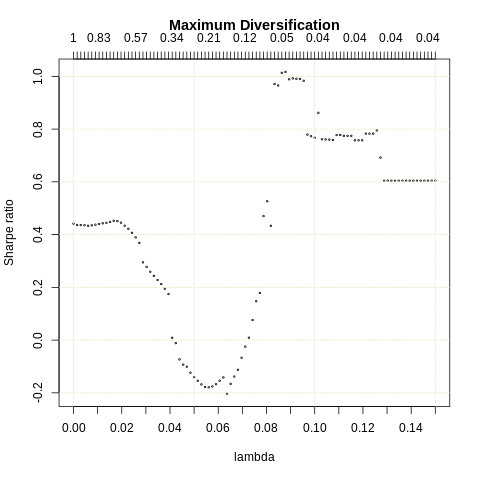

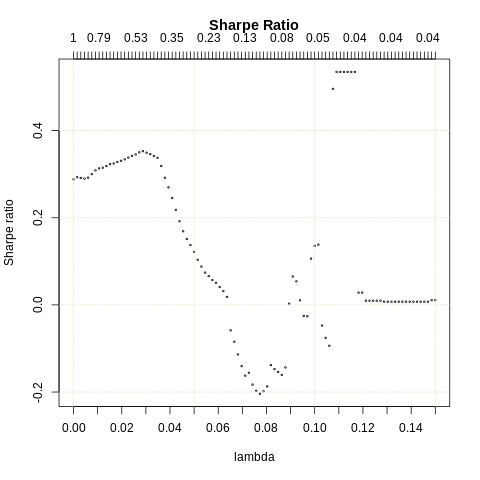

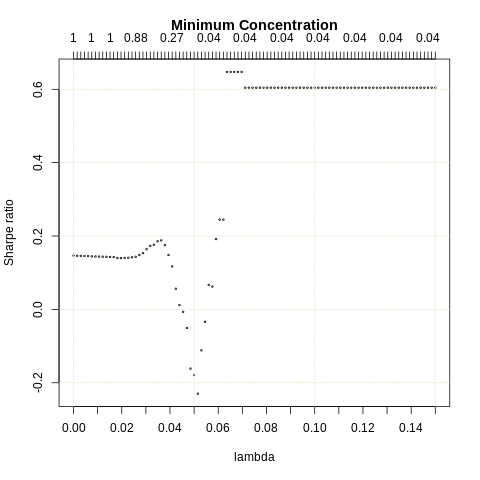

In [ ]:
%%R

require(foreach)
require(data.table)
require(plyr)
require(zoo)
require(xts)
require(lubridate)
require(stringr)
require(elasticnet)
require(PMA)
require(genlasso)
require(pracma)

# Get DAX data
daily_data=fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/DAX30_20070102_20190211.csv", sep=""))

insample_fraction = 0.9
n_folds = 20
n_stocks = 28


sumabsvs = linspace(1.0, sqrt(n_stocks), n=100)
algo1_lamdas = c(linspace(0.0, 0.1, n=100), linspace(0.101, 0.15, n=50))
fbg_lamdas = linspace(0.0, 0.999, n=100)
sparse_lamdas = linspace(0.0, 0.15, n=100)

resulting_returns_dax = optimal_constraints_searcher(daily_data, insample_fraction, n_folds)
temp = resulting_returns_dax
#xx = sharpe_by_fold(temp[["sparse_SR"]], 1966, function(x) {mean(x)/sd(x)})
#plot(sparse_lamdas, apply(xx, 2, mean))



constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(temp$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = algo1_lamdas[which.max(apply(temp$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(temp$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MD[,-100], 2, sum))]
constraints_star[["md_sparse"]]  = 0.02#sparse_lamdas[which.max(apply(temp$sparse_MD[,-100], 2, sum))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(temp$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = algo1_lamdas[which.max(apply(temp$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]] = algo1_lamdas[which.max(apply(temp$fbg_SR, 2, sum))]
constraints_star[["sr_sparse"]]  = 0.03 #sparse_lamdas[which.max(apply(temp$sparse_SR[,-100], 2, sum))]


#constraints_star[["mc_algo1"]] = algo1_lamdas[which.max(apply(temp$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["mc_fbg"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MC[,-100], 2, sum))]
constraints_star[["mc_sparse"]]  = 0.035 #sparse_lamdas[which.max(apply(temp$sparse_MC[,-100], 2, sum))]


dax_oos_stats = results_saver(daily_data, insample_fraction, n_folds, constraints_star)
dax_oos_stats

dax_val_stats = results_in_sample_saver(resulting_returns_dax, constraints_star)
dax_val_stats



#resulting_returns_dax_IS = optimal_constraints_searcher(daily_data, insample_fraction, n_folds, use_train=TRUE)
#temp=resulting_returns_dax_IS

#constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(temp$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = 0.07#algo1_lamdas[which.max(apply(temp$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(temp$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MD, 2, sum))]
#constraints_star[["md_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MD, 2, mean)/apply(temp$sparse_MD, 2, sd))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(temp$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = 0.0 #algo1_lamdas[which.max(apply(temp$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_SR, 2, sum))]
#constraints_star[["sr_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_SR, 2, mean)/apply(temp$sparse_SR, 2, sd))]


#constraints_star[["mc_algo1"]] = 0.06#algo1_lamdas[which.max(apply(temp$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MC, 2, sum))]
#constraints_star[["mc_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MC, 2, mean)/apply(temp$sparse_MC, 2, sd))]

#dax_is_stats = results_in_sample_saver(resulting_returns_dax_IS, constraints_star)



          UNIF     SR      MD     MC
MR      0.0000 0.0000  0.0000 0.0000
STD     0.0155 0.0031  0.0040 0.0147
SR      0.0351 0.1558 -0.0262 0.0321
MR*     0.0000 0.0001  0.0001 0.0001
STD*    0.0155 0.0042  0.0124 0.0124
SR*     0.0351 0.2687  0.1042 0.1758
NonZero 1.0000 0.5319  0.1108 0.2742


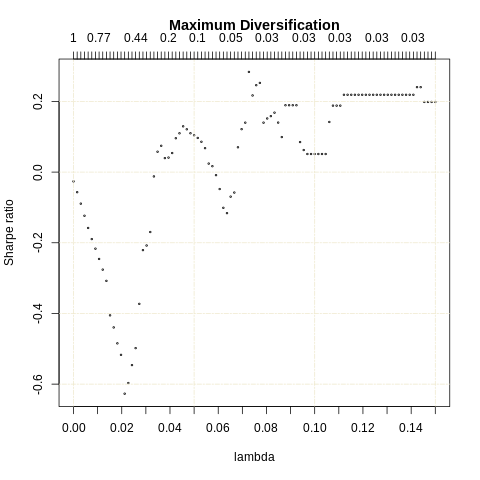

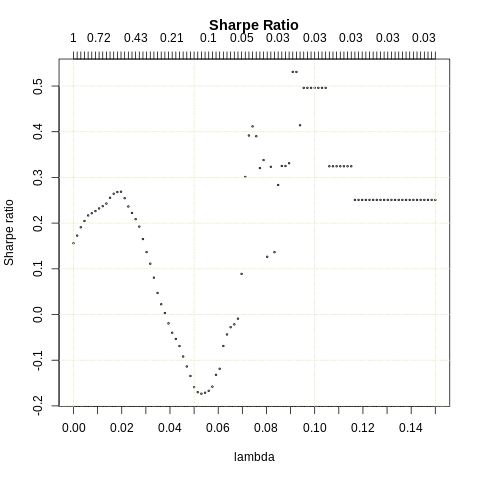

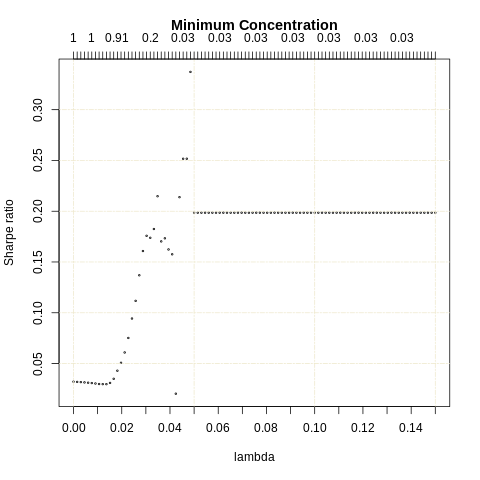

In [ ]:
%%R

# Get CAC data
daily_data=fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/CAC40_20070102_20190211.csv", sep=""))

resulting_returns_cac = optimal_constraints_searcher(daily_data, insample_fraction, n_folds)
temp = resulting_returns_cac

#xx = sharpe_by_fold(resulting_returns_dax[["sparse_SR"]], 1966, function(x) {mean(x)/sd(x)})
#plot(sparse_lamdas, apply(xx, 2, mean))



constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(temp$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = algo1_lamdas[which.max(apply(temp$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(temp$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MD[,-100], 2, sum))]
constraints_star[["md_sparse"]]  = 0.05#sparse_lamdas[which.max(apply(temp$sparse_MD[,-100], 2, sum))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(temp$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = algo1_lamdas[which.max(apply(temp$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]] = algo1_lamdas[which.max(apply(temp$fbg_SR, 2, sum))]
constraints_star[["sr_sparse"]]  = 0.02 #sparse_lamdas[which.max(apply(temp$sparse_SR[,-100], 2, sum))]


#constraints_star[["mc_algo1"]] = algo1_lamdas[which.max(apply(temp$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["mc_fbg"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MC[,-100], 2, sum))]
constraints_star[["mc_sparse"]]  = 0.03 #sparse_lamdas[which.max(apply(temp$sparse_MC[,-100], 2, sum))]


cac_oos_stats = results_saver(daily_data, insample_fraction, n_folds, constraints_star)
cac_oos_stats

cac_val_stats = results_in_sample_saver(resulting_returns_cac, constraints_star)
cac_val_stats


#resulting_returns_cac_IS = optimal_constraints_searcher(daily_data, insample_fraction, n_folds, use_train=TRUE)
#temp=resulting_returns_cac_IS

#constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(temp$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = 0.07#algo1_lamdas[which.max(apply(temp$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(temp$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MD, 2, sum))]
#constraints_star[["md_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MD, 2, mean)/apply(temp$sparse_MD, 2, sd))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(temp$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = 0.0 #algo1_lamdas[which.max(apply(temp$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_SR, 2, sum))]
#constraints_star[["sr_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_SR, 2, mean)/apply(temp$sparse_SR, 2, sd))]


#constraints_star[["mc_algo1"]] = 0.06#algo1_lamdas[which.max(apply(temp$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MC, 2, sum))]
#constraints_star[["mc_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MC, 2, mean)/apply(temp$sparse_MC, 2, sd))]


#cac_is_stats = results_in_sample_saver(resulting_returns_cac_IS, constraints_star)
#cac_is_stats


          UNIF     SR     MD     MC
MR      0.0005 0.0000 0.0001 0.0005
STD     0.0100 0.0021 0.0024 0.0093
SR      0.7752 0.2280 0.6933 0.7687
MR*     0.0005 0.0001 0.0003 0.0006
STD*    0.0100 0.0050 0.0078 0.0307
SR*     0.7752 0.2385 0.5930 0.3322
NonZero 1.0000 0.1593 0.1432 0.0457


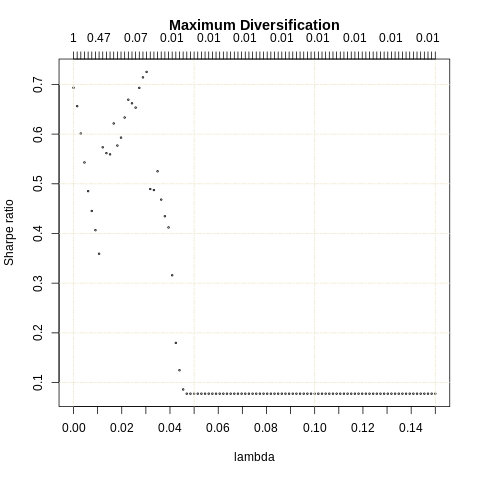

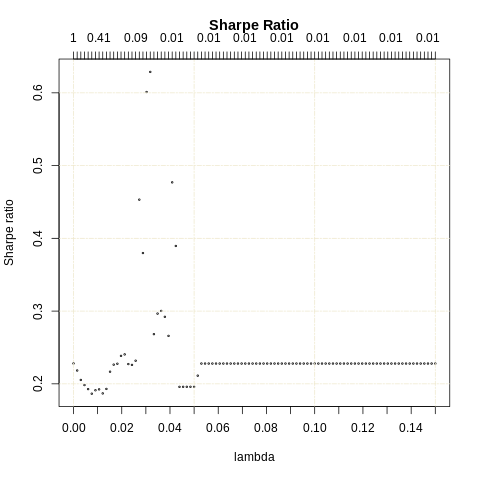

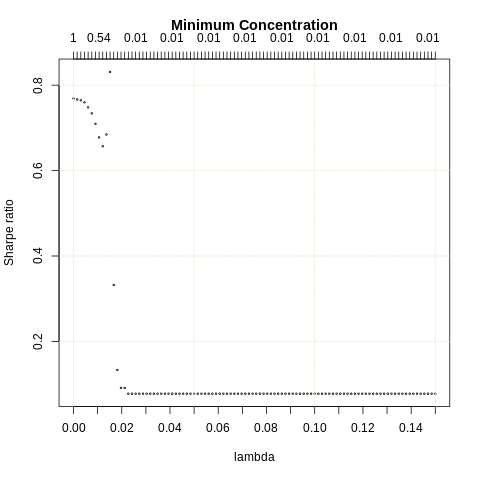

In [ ]:
%%R


# Get FTSE data
daily_data=fread(paste("/content/drive/MyDrive/data_papers/",paper_name,"/FTSE100_20070102_20190211.csv", sep=""))
n_folds = 10
resulting_returns_ftse = optimal_constraints_searcher(daily_data, insample_fraction, n_folds)

#xx = sharpe_by_fold(resulting_returns_dax[["sparse_SR"]], 1966, function(x) {mean(x)/sd(x)})
#plot(sparse_lamdas, apply(xx, 2, mean))



constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(resulting_returns_dax$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = algo1_lamdas[which.max(apply(resulting_returns_dax$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(resulting_returns_dax$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(resulting_returns_dax$fbg_MD[,-100], 2, sum))]
constraints_star[["md_sparse"]]  = 0.02#sparse_lamdas[which.max(apply(resulting_returns_dax$sparse_MD[,-100], 2, sum))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(resulting_returns_dax$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$fbg_SR, 2, sum))]
constraints_star[["sr_sparse"]]  = 0.02 #sparse_lamdas[which.max(apply(resulting_returns_dax$sparse_SR[,-100], 2, sum))]


#constraints_star[["mc_algo1"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$modpmd_MC, 2, sum))]
#constraints_star[["mc_fbg"]] = algo1_lamdas[which.max(apply(resulting_returns_dax$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(resulting_returns_dax$fbg_MC[,-100], 2, sum))]
constraints_star[["mc_sparse"]]  = 0.017 #sparse_lamdas[which.max(apply(resulting_returns_dax$sparse_MC[,-100], 2, sum))]


ftse_oos_stats = results_saver(daily_data, insample_fraction, n_folds, constraints_star)
ftse_oos_stats

ftse_val_stats = results_in_sample_saver(resulting_returns_ftse, constraints_star)
ftse_val_stats

#resulting_returns_ftse_IS = optimal_constraints_searcher(daily_data, insample_fraction, n_folds, use_train=TRUE)
#temp=resulting_returns_ftse_IS

#constraints_star = list()
#constraints_star[["md_pmd"]] = sumabsvs[which.max(apply(temp$pmd_MD, 2, sum))]
#constraints_star[["md_algo1"]]  = 0.07#algo1_lamdas[which.max(apply(temp$algo1_MD, 2, sum))]
#constraints_star[["md_modpmd"]]  = algo1_lamdas[which.max(apply(temp$modpmd_MD, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MD, 2, sum))]
#constraints_star[["md_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MD, 2, mean)/apply(temp$sparse_MD, 2, sd))]


#constraints_star[["sr_pmd"]] = sumabsvs[which.max(apply(temp$pmd_SR, 2, sum))]
#constraints_star[["sr_algo1"]] = 0.0 #algo1_lamdas[which.max(apply(temp$algo1_SR, 2, sum))]
#constraints_star[["sr_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_SR, 2, sum))]
#constraints_star[["sr_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_SR, 2, sum))]
#constraints_star[["sr_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_SR, 2, mean)/apply(temp$sparse_SR, 2, sd))]


#constraints_star[["mc_algo1"]] = 0.06#algo1_lamdas[which.max(apply(temp$algo1_MC, 2, sum))]
#constraints_star[["mc_modpmd"]] = algo1_lamdas[which.max(apply(temp$modpmd_MC, 2, sum))]
#constraints_star[["md_fbg"]]  = fbg_lamdas[which.max(apply(temp$fbg_MC, 2, sum))]
#constraints_star[["mc_sparse"]]  = sparse_lamdas[which.max(apply(temp$sparse_MC, 2, mean)/apply(temp$sparse_MC, 2, sd))]


#ftse_is_stats = results_in_sample_saver(resulting_returns_cac_IS, constraints_star)
#ftse_is_stats





In [ ]:
%%R

data_splits = data_transformer(daily_data, insample_fraction)
allDataWithZeros_IS = data_splits$IS
allDataWithZeros_OOS = data_splits$OOS
n_stocks = ncol(allDataWithZeros_OOS)
folds = ts_crossValidation(allDataWithZeros_IS, n_folds)
tr_tbl = folds[[1]]
avg_ret = apply(tr_tbl, 2, mean) * 100
sigma_tr = as.vector(apply(tr_tbl, 2, sd))
cov_mtrx <- cov(tr_tbl, use="pairwise.complete.obs")


In [ ]:
%%R

dim(daily_data)

[1] 3062  496


In [ ]:
%%R


# sum(abs(folds[[2]] %*% resulting_returns_dax$ws_SR_sparse[1:28,] - resulting_returns_dax$sparse_SR[1:491,])) 

# resulting_returns_dax$ws_SR_sparse[1:28,1] 

# resulting_returns_dax$ws_gen_SR[1:28,1] 


# Implement Paper



In [ ]:
%%R

# devtools::install_github("astamm/nloptr")
# https://github.com/astamm/nloptr

R[write to console]: Downloading GitHub repo astamm/nloptr@HEAD



In [109]:
%%R

library(PMA)
library(pracma)

gen_vec_with_norm_less_than <- function(l, scale, p=2) {
  vec = rand(1, l)
  vec = vec*scale / pracma::Norm(vec, p)
  return(vec)
}

gen_len1_u_subjB <- function(B, ceiling=1.0, scaling = NULL, max_iter = 50) {
  
  if(is.null(scaling)) { scaling = runif(1,0.001,ceiling/4.0) }  
  u_of_length_1 = gen_vec_with_norm_less_than(ncol(B), scaling, 2)
  iter = 0 
  while( (u_of_length_1 %*% B %*% t(u_of_length_1) > ceiling) & (iter < max_iter)   ) {
    u_of_length_1 = gen_vec_with_norm_less_than(ncol(B), scaling, 2)  
    iter = iter + 1
  }
  return(u_of_length_1)
}


### Introduction
# Parameters
p <- 10
c <- 1.2  # budget on L1

# Random A and B PSD matrices
Ip <- diag(p)
A <- rWishart(1,p,Ip)[,,1]/p
B <- rWishart(1,p,Ip)[,,1]/p

# Deriving C and M
C <- sqrtm(B)$Binv%*%A%*%sqrtm(B)$Binv
M <- sqrtm(B)$Binv%*%sqrtm(A)$B

# Verify that MM^T and C are the same
M%*%t(M) - C

sqrtm(B)$Binv-solve(sqrtm(B)$B)

### PCA, sparse PCA and Penalised Matrix Decomposition
pca <- prcomp(C)
spc <- SPC(C, sumabsv = c, center = FALSE)
pmd <- PMD(M,"standard", sumabsu = 0.3, sumabsv = NULL, center = FALSE)

# pca$rotation[,1]
# spc$v
# pmd$u
# all(eigen(C)$values > 0.0)

MtM = t(M)%*%M
invB = solve(B)
invB2 = invB %*% invB




12
1234


In [110]:
import numpy as np
import pandas as pd
import scipy as sp

A = %R A
B = %R B
M = %R M
A = np.array(A)
B = np.array(B)
Binv = %R invB
BinvSq = %R invB2

M = np.array(M)
MTM = np.matmul(M.transpose(),M)

# print(M)


In [111]:
def gen_vec_with_norm_less_than(l, scale, p=2):
    vec = np.random.uniform(0.0,1.0, l)
    vec = vec*scale / np.linalg.norm(vec, p)
    return(vec)

def gen_len1_u_subjB(B, ceiling=1.0, scaling = np.nan, max_iter = 50):    
  if np.isnan(scaling):
      scaling = np.random.uniform(0.001,ceiling/4.0, 1)

  u_of_length_1 = gen_vec_with_norm_less_than(B.shape[1], scaling, 2)
  iter = 0 
  while  ( np.matmul(np.matmul(u_of_length_1,B), u_of_length_1.transpose()) > ceiling ) & (iter < max_iter): 
    u_of_length_1 = gen_vec_with_norm_less_than(B.shape[1], scaling, 2)  
    iter = iter + 1
  
  return(u_of_length_1)



In [141]:
np.random.seed(1234)

u_init = gen_len1_u_subjB(B).transpose()

budget = 1.2
max_iter = 10
iter = 0
eps = 1e-10
converged = False
vsl = []
usl = [ u_init ]

u_step = u_init

In [142]:
# %pip install pyomo
# %pip install glpk
print( np.all(np.linalg.eig(B)[0]>0.0) )
print( np.all(np.linalg.eig(A)[0]>0.0) )

True
True


In [143]:
np.linalg.norm(u_step,2)
# np.linalg.norm(v_step,2)

0.04868834314434418

In [144]:
from cvxpy import *

change = None

lamb = Parameter(nonneg=True)
lamb = budget

while( (iter < max_iter) & (~converged) ):

  u_step_before = u_step[:]
  v_step = np.matmul(M, u_step)/np.sqrt( np.matmul(np.matmul(u_step.transpose(),MTM),u_step)  )

        # need to find a QCQP solver (linear objective here but quadratic constraint)
        # https://scicomp.stackexchange.com/questions/29988/how-to-efficiently-solve-a-qcqp-with-dynamic-constraints-in-python
        # https://math.stackexchange.com/questions/2583213/convex-qcqp-in-cvxopt
        # https://programtalk.com/vs2/?source=python/2718/cvxpy/examples/qcqp.py
  
  u_local = Variable(B.shape[0])
  to_min_func = -u_local.T@M@v_step 
  obj_local = Minimize(to_min_func)
  constraints_local = [ quad_form(u_local, B) <= 1.0,  norm(u_local, 1) <=lamb] 
  local_prob = Problem(obj_local, constraints_local)
  local_prob.solve()
  u_step = u_local.value

  # for FW later...
  # u_step = u_step / np.linalg.norm(u_step, 2)
  # d_step = -np.matmul(M,v_step) + budget * np.sign(u_step)
  # s_step = np.matmul(Binv,d_step)/np.sqrt( np.matmul(np.matmul(d_step.transpose(),BinvSq),d_step)  )
  # u_step_before = u_step[:]
  # u_step = u_step + ( 2.0 / ( iter + 2.0) ) * (s_step - u_step)
  # print([v_step, u_step])

  change = np.sqrt(np.sum(np.square(u_step - u_step_before)))  
  print(change)

  if change < eps:
    converged = True
    print(change)

  # and now for 
  iter = iter + 1


print(change)


1.1218885991171443
1.1147313873961863e-10
2.2125276586486012e-14
2.2125276586486012e-14
2.2125276586486012e-14


In [145]:
np.matmul(u_step.transpose(),B)@u_step

1.000000000443986

In [146]:
np.linalg.norm(u_step,2)

1.1384577797366127

In [147]:
np.trace(B)

12.086520983258886

In [148]:
np.sqrt(np.matmul(u_step.transpose(),u_step))

1.1384577797366127

In [149]:
np.linalg.norm(u_step,1)

1.1999999995398312

In [150]:
u_step

array([ 8.46077683e-12, -6.33035691e-02,  9.76326335e-11,  1.13669643e+00,
       -3.26642557e-11, -1.19406081e-10,  3.37163010e-12, -3.88865422e-12,
        1.30380219e-11,  1.64054038e-11])

In [ ]:
|# https://colab.research.google.com/github/cvxpy/cvxpy/blob/master/examples/notebooks/WWW/quadratic_program.ipynb#scrollTo=j8FgcFzTHFrS

# Import packages.
import cvxpy as cp
import numpy as np

# Generate a random non-trivial quadratic program.
m = 15
n = 10
p = 5
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T@P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G@np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

# Define and solve the CVXPY problem.
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x, P) + q.T@x),
                 [G@x <= h,
                  A@x == b])
prob.solve()

# Print result.
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)



The optimal value is 86.89141585569907
A solution x is
[-1.68244521  0.29769913 -2.38772183 -2.79986015  1.18270433 -0.20911897
 -4.50993526  3.76683701 -0.45770675 -3.78589638]
A dual solution corresponding to the inequality constraints is
[ 0.          0.          0.          0.          0.         10.45538054
  0.          0.          0.         39.67365045  0.          0.
  0.         20.79927156  6.54115873]


In [ ]:
# u_of_length_1 = gen_vec_with_norm_less_than(5, 1.0, 2)
# u_of_norm_1 = gen_vec_with_norm_less_than(4, 1, 1)

# print(np.linalg.norm(u_of_length_1, 2))
# print(np.linalg.norm(u_of_norm_1, 1))

# print(np.linalg.norm(u_of_length_1, 1))
# print(np.linalg.norm(u_of_norm_1, 2))




1.0
1.0
2.1382969710752837
0.5346964253077028


In [ ]:
%%R

# u_of_length_1 = gen_vec_with_norm_less_than(5, runif(1,0.001,0.25), 2)
# u_of_length_1 %*% B %*% t(u_of_length_1)
# u_of_length_1 = gen_vec_with_norm_less_than(4, 1, 2)
# u_of_norm_1 = gen_vec_with_norm_less_than(4, 1, 1)

# print(u_of_length_1 %*% t(u_of_length_1))
# print(u_of_norm_1 %*% t(u_of_norm_1))

# print(Norm(u_of_length_1,2))
# print(Norm(u_of_length_1, 1))

# print(Norm(u_of_norm_1,2))
# print(Norm(u_of_norm_1, 1))

# # runif(1)
# # rand(1,10)
# gen_len1_u_subjB(B)


           [,1]      [,2]      [,3]       [,4]       [,5]
[1,] 0.09587938 0.1334059 0.0560485 0.07362959 0.03723668


In [ ]:
%%R
M2

            [,1]       [,2]        [,3]        [,4]        [,5]
[1,]  1.02426695 -0.2888609 -0.15007366  0.13178849 -0.40452184
[2,] -0.10912902  1.1886845  0.05144153 -0.02405376  0.29358149
[3,] -0.04791129  0.1869160  1.26297984  0.03692281  0.37616477
[4,]  0.25419971 -0.2103509 -0.35357102  0.62777474 -0.05584816
[5,] -0.25679451  0.2704278  0.41981252  0.09682964  0.58039203


In [ ]:
%%R


set.seed(1234)

v_init = gen_vec_with_norm_less_than(ncol(B), runif(1,0.5,0.999), 2)
u_init = t(gen_len1_u_subjB(B))

max_iter = 10
iter = 0
eps = 1e-10
converged = FALSE
vs = c()
us = c(u_init)

u_step = u_init
M = M2
MTM = t(M) %*% M




In [ ]:
%%R

dim(u_step)

print(M %*% u_step)
# / sqrt( t(u_step) %*% MTM %*% u_step  )

sqrt(t(u_step) %*% MTM %*% u_step)



              [,1]
[1,] -0.0004349226
[2,]  0.0025378191
[3,]  0.0026931763
[4,]  0.0003853881
[5,]  0.0019511995
            [,1]
[1,] -0.10297499
[2,]  0.60086992
[3,]  0.63765324
[4,]  0.09124689
[5,]  0.46197819


In [ ]:
%%R
u_step


             [,1]
[1,] 0.0006304235
[2,] 0.0018056930
[3,] 0.0013940885
[4,] 0.0018802634
[5,] 0.0014773776


In [ ]:
%%R

require(CVXR)

us <- CVXR::Variable(ncol(B))




R[write to console]: Loading required package: CVXR

R[write to console]: Error in loadNamespace(x) : there is no package called ‘CVXR’

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘CVXR’




Error in loadNamespace(x) : there is no package called ‘CVXR’


RInterpreterError: ignored